# Find Best Paths Between ODs

In [46]:
import os
import sys
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
import pandas as pd

if manual:
    %matplotlib inline

In [47]:
is_lambda = (os.environ.get("AWS_LAMBDA_FUNCTION_NAME") is not None)

if is_lambda:
    model_folder = 's3://quetzal-paris/dev'
    training_folder = os.environ.get("LAMBDA_TASK_ROOT")
else:
    model_folder = '../../model'
    training_folder = '../..'
    
input_folder = training_folder + '/inputs/'

## Read Model

In [48]:
sm = stepmodel.read_zippedpickles(model_folder + '/{scen}/walk_model'.format(scen=scenario))

zone_to_transit: 100%|██████████| 29/29 [00:01<00:00, 22.07it/s]


# Preparation

In [49]:
# Set headway of 5 minutes for each transport line
sm.links['headway'] = 300

# Set car speed as 25% faster than bus speed
bus = sm.links.loc[sm.links['route_type'] == 'bus']
car_speed = (bus['road_length'].sum() / bus['time'].sum()) * 1.25
sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s
print(f'Car Speed: {car_speed * 3.6}  km/h')

# Set walk time on road network
sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walk three times slower than car

Car Speed: 22.852996621315192  km/h


# PT Pathfinder
## Walk On Road
People walks on the road network, slower computation

In [50]:
wor = sm.copy()
wor.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=True)

path_analysis: 100%|██████████| 12100/12100 [00:00<00:00, 63379.51it/s]


## As the Crow Llies
People walks on dedicated access and egress links only 

In [51]:
acf = sm.copy()
acf.step_pt_pathfinder(broken_modes=False, broken_routes=False)

path_analysis: 100%|██████████| 12100/12100 [00:00<00:00, 105346.02it/s]


In [52]:
# here we chose to use the ACF paths
sm.pt_los = acf.pt_los

# Road Pathfinder

In [53]:
sm.step_road_pathfinder(method = 'aon')
sm.car_los.drop(columns=['gtime'], inplace=True)

self.volumes does not exist. od generated with self.zones


# Export

In [54]:
sm.to_zippedpickles(model_folder + '/{scen}/aon_pathfinder'.format(scen=scenario))  

car_los: 100%|██████████| 31/31 [00:02<00:00, 11.55it/s]                


# PLOT

In [55]:
if not manual:
    end_of_notebook
    
import matplotlib.pyplot as plt
import numpy as np

(0.0, 4000.0)

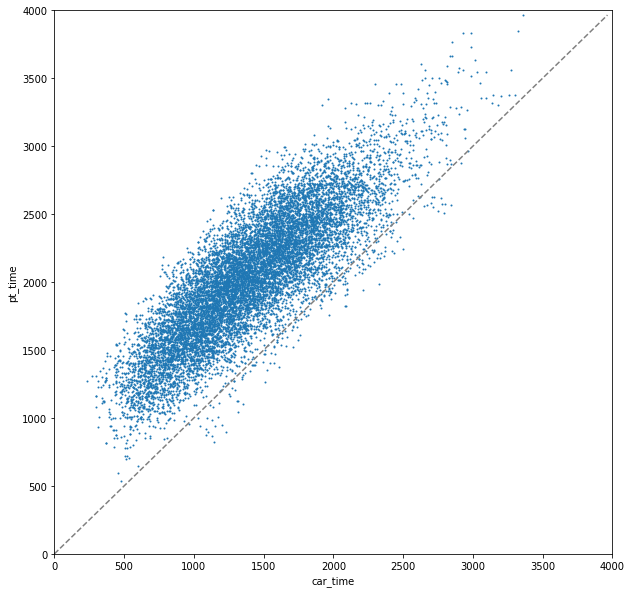

In [56]:
sm.pt_los['pt_time'] = sm.pt_los['gtime']
sm.car_los['car_time'] = sm.car_los['time']
los = pd.merge(sm.pt_los, sm.car_los, on=['origin', 'destination'])
los = los.loc[los['origin'] != los['destination']]
los.plot(kind='scatter', x='car_time', y='pt_time', figsize=[10, 10], s=1)

x = y = np.linspace(0, max(los['pt_time']))
plt.plot(x, y, linestyle='--', color='grey')
plt.xlim([0, np.round(max(los['pt_time']), -3)])
plt.ylim([0, np.round(max(los['pt_time']), -3)])

# END